100%|██████████| 170M/170M [00:36<00:00, 4.67MB/s] 
/home/sfmt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sfmt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30.. Train Loss: 1.6825.. Val Loss: 0.9424.. Val Acc: 0.7029
Epoch 2/30.. Train Loss: 1.4253.. Val Loss: 0.8368.. Val Acc: 0.7266
Epoch 3/30.. Train Loss: 1.3692.. Val Loss: 0.7423.. Val Acc: 0.7568
Epoch 4/30.. Train Loss: 1.3388.. Val Loss: 0.7560.. Val Acc: 0.7415
Epoch 5/30.. Train Loss: 1.3302.. Val Loss: 0.7134.. Val Acc: 0.7563
Epoch 6/30.. Train Loss: 1.3086.. Val Loss: 0.7087.. Val Acc: 0.7593
Epoch 7/30.. Train Loss: 1.2973.. Val Loss: 0.6972.. Val Acc: 0.7621
Epoch 8/30.. Train Loss: 1.2890.. Val Loss: 0.6644.. Val Acc: 0.7694
Epoch 9/30.. Train Loss: 1.2764.. Val Loss: 0.6591.. Val Acc: 0.7753
Epoch 10/30.. Train Loss: 1.2712.. Val Loss: 0.6520.. Val Acc: 0.7746
Epoch 11/30.. Train Loss: 1.2576.. Val Loss: 0.6573.. Val Acc: 0.7748
Epoch 12/30.. Train Loss: 1.2616.. Val Loss: 0.6371.. Val Acc: 0.7787
Epoch 13/30.. Train Loss: 1.2547.. Val Loss: 0.6180.. Val Acc: 0.7896
Epoch 14/30.. Train Loss: 1.2499.. Val Loss: 0.6345.. Val Acc: 0.7804
Epoch 15/30.. Train Loss: 1.2

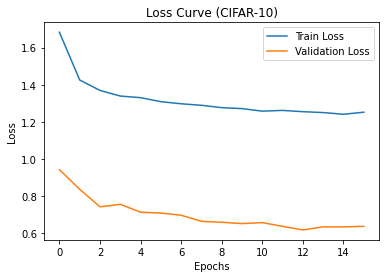

CIFAR-10 Test Accuracy: 0.7896


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# CIFAR-10 
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=data_transforms['train'])
val_dataset = datasets.CIFAR10(root='./data', train=False,
                               download=True, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Softmax
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10) 
)

model = model.to(device)

# CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

epochs = 30
patience = 3
best_loss = np.inf
counter = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 标签不需要float

        optimizer.zero_grad()
        outputs = model(inputs)  
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = correct / total

    print(f'Epoch {epoch+1}/{epochs}.. Train Loss: {epoch_loss:.4f}.. '
          f'Val Loss: {epoch_val_loss:.4f}.. Val Acc: {val_accuracy:.4f}')

    # Early Stopping
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        torch.save(model.state_dict(), 'cifar10_best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve (CIFAR-10)')
plt.legend()
plt.show()

model.load_state_dict(torch.load('cifar10_best_model.pth'))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

print(f'CIFAR-10 Test Accuracy: {correct / total:.4f}')
